In [1]:
from img_doc.dataset import PubLayNetDataset
from img_doc.document import Document

from img_doc.document import Document, Block
from img_doc.document.page.extractors.block_extractors import PageAndWordClassificator, BaseRandomWalkClassificator, BaseRandomDeepNodeClassificator

import numpy as np
import json
import random

import tensorflow as tf
import keras
from keras import layers
from keras.metrics import F1Score

tf.random.set_seed(22)

from time import time
import matplotlib.pyplot as plt
import os

from img_doc.image.segment_clusterizer import GNNClusterizer

2024-03-20 12:26:25.344224: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 12:26:26.236307: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 12:26:26.236507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 12:26:26.390897: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 12:26:26.742475: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 12:26:26.758638: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
pln_ds = PubLayNetDataset(r"/home/daniil/program/dataset/publaynet/", 
                          r"/home/daniil/program/dataset/tmp_publaynet/")

# pln_ds = PubLayNetDataset(r"/media/daniil/data/publaynet/", 
#                            r"/media/daniil/data/tmp_publaynet/")

In [3]:
def shuffle(x_arrays, y_arrays):
    x_vec = np.concatenate(x_arrays)
    y_vec = np.concatenate(y_arrays)
    data = [(x, y) for x, y in zip(x_vec, y_vec)]
    random.shuffle(data)
    x_vec_rnd = np.array([x for x, y in data])
    y_vec_rnd = np.array([y for x, y in data])
    return x_vec_rnd, y_vec_rnd
    

def get_data(dataset, balans=True): #, batch_size=128

    X = np.array(dataset["x"])
    y = np.array(dataset["y"])
    
    keys = np.unique(y)
    Y_keys = dict()
    for i, key in enumerate(keys):
        z = np.zeros(2)
        z[i] = 1
        Y_keys[key] = z
    Y = np.array([Y_keys[yi] for yi in y])

    X_clus_list = []
    Y_clus_list = []

    for i, item in enumerate(Y_keys.keys()):
        X_clus_list.append(X[Y[:,i]==1,:])
        Y_clus_list.append(Y[Y[:,i]==1,:])
        
    if balans:
        balans_len = [len(yc) for yc in Y_clus_list]
        min_len = min(balans_len)
    
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    val_x = []
    val_y = []
    for class_data in zip(X_clus_list, Y_clus_list):
        data = [(x, y) for x, y in zip(class_data[0], class_data[1])]
        random.shuffle(data)
        if balans:
            data = data[:min_len]
        len_data = len(data)
        len_test = round(0.2*len_data)
        len_val = round((len_data-len_test)*0.2)
        len_train = len_data - len_test - len_val
        
        train_x.append([x for x, y in data[:len_train]])
        train_y.append([y for x, y in data[:len_train]])
        
        val_x.append([x for x, y in data[len_train:len_train+len_val]])
        val_y.append([y for x, y in data[len_train:len_train+len_val]])
    
        test_x.append([x for x, y in data[-len_test:]])
        test_y.append([y for x, y in data[-len_test:]])
        
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y, Y_keys

def save_dataset(pwc, name, set_, path_dir_jsons, count_train_files=100):
    def fun_from_tmp_and_path_image(tmp_json, img_path):
        doc = Document()
        doc.set_from_path(img_path)
        doc.pages[0].set_blocks_from_dict(tmp_json["blocks"])
        doc.pages[0].set_words_from_dict(tmp_json["additional_info"]["words"])
        if "bold" in set_:
            doc.pages[0].extract_word_bold()
        for word in doc.pages[0].words:
            for block in doc.pages[0].blocks:
                if block.segment.is_intersection(word.segment):
                    block.words.append(word)
        x = []
        y = []

        set_segs = [w.segment for w in page.words]
        try:

            xi = gnn_clusterizer.get_vecs(set_segs)
            neighbors = gnn_clusterizer.get_index_neighbors_segment(set_segs)
            for i, w in enumerate(page.words):
                for b in page.blocks:
                    if w in b.words:
                        red = False
                        for node in neighbors[i]:
                            w2 = page.words[node]
                            if not (w2 in b.words) or w2 == w:
                                red = True
                        y.append([1 if red else 0, b.label])
                        x.append(xi[i])
        except:
            print("file", img_path)
        
        return {"x": x, "y": y}
    
    pln_ds.create_json_from_tmps_and_images(fun_from_tmp_and_path_image, 
                                                path_dir_jsons=path_dir_jsons, 
                                                count_train_files=count_train_files,  
                                                balans = True)


In [4]:
gnn_clusterizer = GNNClusterizer()

In [5]:
list_file = pln_ds.get_list_file_name()
list_file[:5]

['PMC3437971_00001.jpg',
 'PMC4631444_00001.jpg',
 'PMC5486610_00004.jpg',
 'PMC4422455_00003.jpg',
 'PMC5831887_00003.jpg']

In [6]:
doc = pln_ds.read_file(list_file[3])
page = doc.pages[0]

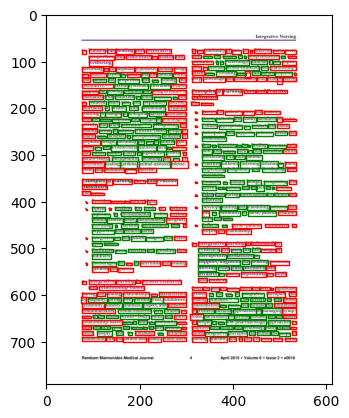

In [7]:
set_segs = [w.segment for w in page.words]
indicator = []
n = gnn_clusterizer.get_index_neighbors_segment(set_segs)
# gnn_clusterizer.get_vecs(set_segs)
page.image.plot()

for i, w in enumerate(page.words):
    for b in page.blocks:
        nodes = n[i]
        if w in b.words:
            red = False
            for node in nodes:
                w2 = page.words[node]
                if not (w2 in b.words) or w2 == w:
                    red = True
            if red:
                w.segment.plot("r")
            else:
                w.segment.plot("g")



In [8]:
gnn_clusterizer.get_vecs(set_segs)

[[-0.005169172932330823,
  0.03324287652645862,
  0.009073948439620082,
  -0.002114661654135347,
  -0.0005552873380451119,
  0.0015667465208754642,
  -0.0006177668122724588,
  -0.0016090224850076342,
  -0.0015569242192356593,
  -0.0014551443317865126],
 [-0.01832706766917294,
  0.01051560379918589,
  0.002778661587823015,
  -0.010536964017914529,
  -0.006589578066886857,
  -0.0004046003909717561,
  -0.0017543371111958853,
  -0.004726555209471504,
  -0.003707155880040134,
  -0.002313958220408354],
 [0.030075187969924803,
  0.004070556309362282,
  0.0028833107191316145,
  0.01679981203007519,
  0.009371514518413147,
  0.004405345857010233,
  0.004602852370655532,
  0.0058747434283833765,
  0.004557035835211508,
  0.0042267514353524285],
 [0.0061090225563909875,
  0.004748982360922655,
  0.00648964093153508,
  0.0002509028677528285,
  0.001626808804044541,
  0.005809869280841287,
  0.004621110788504061,
  0.002982125360602267,
  0.0035218243461232843,
  0.003870996205111359],
 [-0.0089285

In [9]:
brwc = BaseRandomWalkClassificator(conf={"properties": ["hist_ang", "hist_bold", "hist_dist", "hist_height"], "count_step":0})
# brdc = BaseRandomDeepNodeClassificator({"properties":["many_dist", "many_angle", "place_in_block", "height", "bold", "hist_dist", "hist_ang"],
#                                         "count_node":1, 
#                                         "deep":2 })
pwc = PageAndWordClassificator(brwc, conf={"properties":["place_in_page", "count_word_in_page"]})

save_dataset(pwc, name="dataset_5.json", set_=["bold"], path_dir_jsons="dataset_tmp7", count_train_files=50)

train:


In [9]:
def dataset_from_jsons(count_train_files, name_dir):
    dataset = {"x":[], "y": []}
    base_name_file = os.path.join(name_dir, "train_") 
    for i in range(count_train_files):
        with open(f"{base_name_file}{0}.json", "r") as f:
            rez = json.load(f)
        for doc in rez["train"]:
            for x in doc["x"]:
                dataset["x"].append(x)
            for y in doc["y"]:
                
                dataset["y"].append(y[0])
    return dataset

In [10]:
name = "dataset_7.json"
dataset = dataset_from_jsons(count_train_files=20, name_dir="dataset_tmp7")

train_x, train_y, val_x, val_y, test_x, test_y, _ = get_data(dataset)

with open(name, "w") as f:
    json.dump({"train_x": train_x.tolist(), "train_y": train_y.tolist(),
               "val_x": val_x.tolist(), "val_y": val_y.tolist(), 
               "test_x": test_x.tolist(), "test_y": test_y.tolist()}, f)
    
del train_x, train_y, val_x, val_y, test_x, test_y, dataset

In [35]:
del train_x, train_y, val_x, val_y, test_x, test_y, dataset

In [11]:
name_model = "GNN1-PLN"
with open("dataset_7.json", "r") as f:
    dataset = json.load(f)

In [12]:
print("Первый x:\n", dataset["train_x"][0])
print("Последний, x:\n", dataset["train_x"][-1])
x_len = len(dataset["train_x"][0])
print("Размер x:\t", x_len)
print("Первый y:\t", dataset["train_y"][0])
print("Последний y:\t", dataset["train_y"][0])
print("Кол-во записей:\t", len(dataset["train_x"]))

Первый x:
 [-0.005169172932330823, -0.005766621438263259, -0.004211219023658892, 0.0015738248570572226, -0.00196148938663514, 0.001168766801420011, 0.0006481174288981062, -0.00020070676385363438, 0.0005481639109167751, 0.00027999651754716584]
Последний, x:
 [0.001409774436090229, -0.005766621438263203, 0.0036706158296558452, 0.003731077995827968, 0.006320890927770637, 0.002506527658791992, 0.00327228631530143, 0.004582855803523755, 0.004175907767546032, 0.003367991110613137]
Размер x:	 10
Первый y:	 [0.0, 1.0]
Последний y:	 [0.0, 1.0]
Кол-во записей:	 2027674


In [14]:
mega_hist = []

In [38]:
train_x, train_y, val_x, val_y, test_x, test_y = dataset["train_x"], dataset["train_y"], dataset["val_x"], dataset["val_y"], dataset["test_x"] , dataset["test_y"]
# train_x = np.array([np.concatenate([ x[-23:]]) for x in train_x])
# val_x =  np.array([np.concatenate([ x[-23:]]) for x in val_x])
# test_x = np.array([np.concatenate([ x[-23:]]) for x in test_x])

# a = np.array(train_y)
# a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# # a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# train_y = a.tolist()

# a = np.array(val_y)
# a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# # a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# val_y = a.tolist()

# a = np.array(test_y)
# a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# # a[a[:, 3] == 1, :] = [0.0, 1.0, 0.0, 0.0, 0.0]
# test_y = a.tolist()

#batch 75 (ac:65) node 40 в конце лучше не ставить большой dropout, а перед 0.2

# for arg in args:
# hist = []
# model = keras.Sequential()

# input_len = len(train_x[0])
# output_len = 2

# list_layer = [(40, 0.1)] # len, dropout
# epochs = 100
# batch_size = 1000 # 75

# model.add(layers.Dense(units=input_len, activation='relu'))
# for lay in list_layer:
#     model.add(layers.Dropout(rate=lay[1], seed=22))
#     model.add(layers.Dense(units=lay[0],  activation='relu'))
# model.add(layers.Dense(units=output_len, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy',
#               F1Score()])

  
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))
hist.append(history)

loss_and_metrics = model.evaluate(test_x, test_y, batch_size=epochs)
loss_and_metrics
mega_hist.append({"hist": hist, "loss_and_metrics": loss_and_metrics, 
                 "list_layer": list_layer, "epochs": epochs, "batch_size": batch_size })

Epoch 1/100
2028/2028 [==============================] - 20s 10ms/step - loss: 0.3876 - accuracy: 0.8172 - f1_score: 0.8156 - val_loss: 0.3386 - val_accuracy: 0.8460 - val_f1_score: 0.8446
Epoch 2/100
2028/2028 [==============================] - 5s 2ms/step - loss: 0.3881 - accuracy: 0.8167 - f1_score: 0.8151 - val_loss: 0.3384 - val_accuracy: 0.8454 - val_f1_score: 0.8438
Epoch 3/100
2028/2028 [==============================] - 4s 2ms/step - loss: 0.3865 - accuracy: 0.8171 - f1_score: 0.8155 - val_loss: 0.3363 - val_accuracy: 0.8421 - val_f1_score: 0.8411
Epoch 4/100
2028/2028 [==============================] - 3s 2ms/step - loss: 0.3685 - accuracy: 0.8278 - f1_score: 0.8264 - val_loss: 0.3107 - val_accuracy: 0.8629 - val_f1_score: 0.8620
Epoch 5/100
2028/2028 [==============================] - 3s 1ms/step - loss: 0.3627 - accuracy: 0.8300 - f1_score: 0.8286 - val_loss: 0.3096 - val_accuracy: 0.8481 - val_f1_score: 0.8470
Epoch 6/100
2028/2028 [==============================] - 3s 2ms

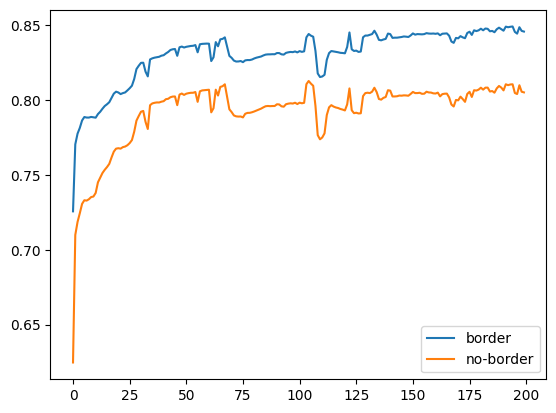

In [39]:
w = model.get_weights()
plt.plot(np.concatenate([h.history['f1_score'] for h in hist]))
# plt.legend(["no_struct", "text", "header",  "list", "table"])
plt.legend(["border", "no-border"])

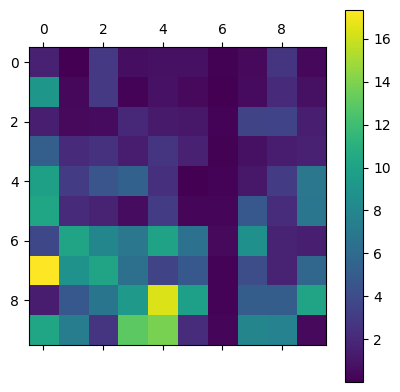

In [40]:
plt.matshow(abs(w[0]))
plt.colorbar()

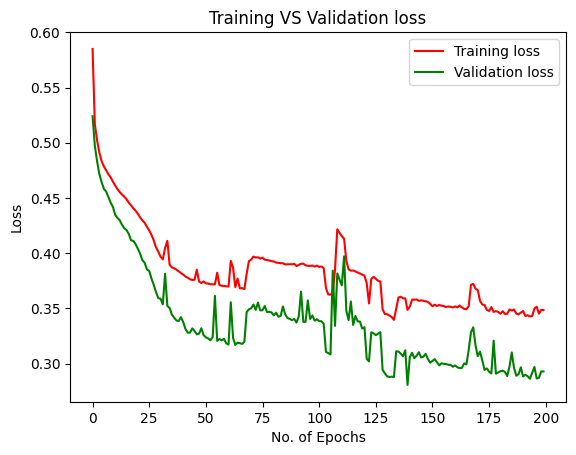

In [41]:
plt.plot(np.concatenate([h.history['loss'] for h in hist]), 'r', label='Training loss')
plt.plot(np.concatenate([h.history['val_loss'] for h in hist]), 'g', label='Validation loss')
plt.title('Training VS Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

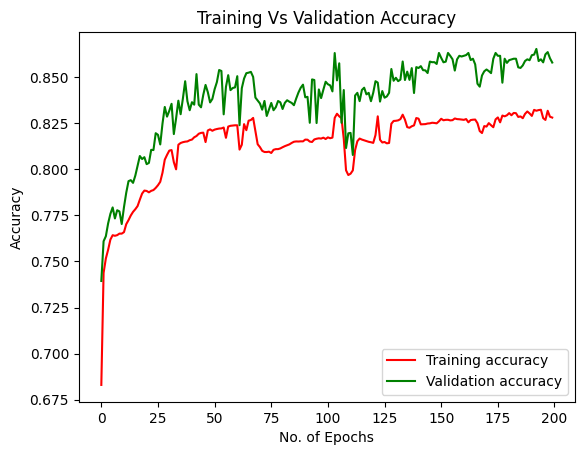

In [42]:
plt.plot(np.concatenate([h.history['accuracy'] for h in hist]), 'r', label='Training accuracy')
plt.plot(np.concatenate([h.history['val_accuracy'] for h in hist]), 'g', label='Validation accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

27/27 [==============================] - 0s 2ms/step


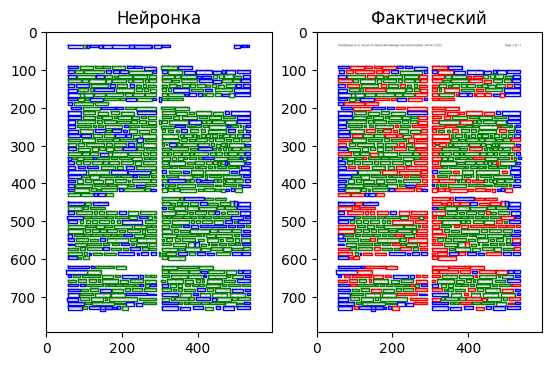

In [43]:
gnn_clusterizer = GNNClusterizer()

list_file = pln_ds.get_list_file_name()
list_file[:5]
doc = pln_ds.read_file(list_file[5])
page = doc.pages[0]

plt.subplot(1, 2, 1)
plt.title("Нейронка")


set_segs = [w.segment for w in page.words]
indicator = []
n = gnn_clusterizer.get_index_neighbors_segment(set_segs)
rez = gnn_clusterizer.get_vecs(set_segs)
rez = model.predict(rez)
page.image.plot()
# color = {0:"r", 1:"g", 2:"b", 3:"k", 4:"k"}
color = {1:"b", 0:"g"}

for i, w in enumerate(page.words):
    w.segment.plot(color[rez[i].argmax()])


plt.subplot(1, 2,2)
plt.title("Фактический")
set_segs = [w.segment for w in page.words]
indicator = []
n = gnn_clusterizer.get_index_neighbors_segment(set_segs)
# gnn_clusterizer.get_vecs(set_segs)
page.image.plot()

for i, w in enumerate(page.words):
    for b in page.blocks:
        nodes = n[i]
        if w in b.words:
            red = False
            for node in nodes:
                w2 = page.words[node]
                if not (w2 in b.words) or w2 == w:
                    red = True
            if red and rez[i].argmax() == 1:
                w.segment.plot("b")
            elif red and rez[i].argmax() == 0:
                w.segment.plot("r")
            elif not red and rez[i].argmax() == 0:
                w.segment.plot("g")
            else:
                w.segment.plot("r")

In [23]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, input_len], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    print(y)
    y = self.class_pred(y)
    return y

def preprocess_test(x):
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return y

In [24]:
mlp_model_export = ExportModule(model=model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

In [25]:
save_path = "GNN1 - PLN"
tf.saved_model.save(mlp_model_export, save_path)
mlp_loaded = tf.saved_model.load(save_path)

Tensor("sequential/dense_2/Softmax:0", shape=(None, 2), dtype=float32)
INFO:tensorflow:Assets written to: GNN1 - PLN/assets


INFO:tensorflow:Assets written to: GNN1 - PLN/assets


In [26]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

test_classes = mlp_loaded(test_x)
test_acc = accuracy_score([np.argmax(y) for y in test_classes], [np.argmax(y) for y in test_y])
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.847


In [90]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 262.0 kB/s eta 0:00:00 MB/s eta 0:00:01
